# Multiple-objective portfolio optimization

# INTRODUCTION

Your task is to solve a multiple-objective portfolio optimization problem.
-  Use the basic Markowitz's model from 1952 (see Lecture 1)
-  Solve = construct Pareto front approximations.
-  The dataset is the same as for the portfolio game part 1 (bundle1.zip).
-  The dataset consists of the historical prices of 20 assets.
-  The bundle contains 20 files (*.txt) linked to different assets.
-  The name of the file suggests the asset's name.
-  The structure of every file is as follows:
1.  The first line contains the name of the asset.
2. The second line provides the number of data points N.
3. The following N lines are data points with the structure: time, price.
-  The historical timeline for all assets is time $\in$ [0,100].
-  Future predictions should be calculated for time = 200.

Goal: 
-  Load data, make predictions, and build the model. 
-  Illustrate your predictions (can be done in the jupyter notebook)
-  Then, implement the WSM and ECM methods (see the tutorial on quadratic programming provided below). 
-  Run your implementations for different calculation limits (e.g., the number of weight vectors for WSM). Compare the methods' efficiency in finding unique Pareto optimal solutions. Finally, illustrate generated Pareto fronts.

# Short tutorial on the cvxopt library for quadratic programming

In [119]:
import numpy as np
from cvxopt import matrix, solvers

# QP Optimization Problem

### General model:

$max$ $\boldsymbol{cx} - \dfrac{1}{2}\boldsymbol{x}^T\boldsymbol{Qx}$ <br>
$s.t.$ <br>
$\boldsymbol{Gx} \leq \boldsymbol{h}$ <br>
$\boldsymbol{x} \geq \boldsymbol{0}$

### But the library uses the following form:

$min$ $\boldsymbol{cx} + \dfrac{1}{2}\boldsymbol{x}^T\boldsymbol{Qx}$ <br>
$s.t.$ <br>
$\boldsymbol{Gx} \leq \boldsymbol{h}$ <br>
$\boldsymbol{Ax} = \boldsymbol{b}$ <br>

### Exmple

$min$ $2x^2_1+x_2^2+x_1x_2+x_1+x_2$ <br>
$s.t.$ <br>
$x_1 \geq 0$<br>
$x_2 \geq 0$<br>
$x_1 + x_2 = 1$<br>

### Hence:

In [120]:
Q = matrix([ [4.0, 1.0], [1.0, 2.0] ]) ## [4, 1] is 1st column, not row!

In [121]:
c = matrix([1.0, 1.0]) ### (1, 2) = dimensions (1 row and 2 columns)

In [122]:
A = matrix([1.0, 1.0], (1,2)) ### (1, 2) = dimensions (1 row and 2 columns)

In [123]:
b = matrix(1.0) 

In [124]:
G = matrix([[-1.0,0.0],[0.0,-1.0]]) ### multiplied both sides by -1

In [125]:
h = matrix([0.0,0.0]) ### multiplied both sides by -1

In [126]:
solQP=solvers.qp(Q, c, G, h, A, b)

In [127]:
print(solQP.keys())

dict_keys(['x', 'y', 's', 'z', 'status', 'gap', 'relative gap', 'primal objective', 'dual objective', 'primal infeasibility', 'dual infeasibility', 'primal slack', 'dual slack', 'iterations'])


In [128]:
print(solQP['x'])
print(solQP['primal objective'])

[ 2.50e-01]
[ 7.50e-01]

1.875000000000018


# We can also solve LP problems:

$min$ $\boldsymbol{c}\boldsymbol{x}$ <br>
$s.t.$ <br>
$\boldsymbol{Gx} \leq \boldsymbol{h}$ <br>
$\boldsymbol{Ax} = \boldsymbol{b}$ (optional)

### Exmple

$min$ $2x_1+x_2$ <br>
$s.t.$ <br>
$-x_1 +x_2 \leq 1$ <br>
$x_1 + x_2 \geq 2$ <br>
$x_2 \geq 0$<br>
$x_1 - 2x_2 \leq 4$

In [129]:
G = matrix([ [-1.0, -1.0, 0.0, 1.0], [1.0, -1.0, -1.0, -2.0] ])
h = matrix([ 1.0, -2.0, 0.0, 4.0 ])
c = matrix([ 2.0, 1.0 ])
solLP = solvers.lp(c,G,h)  
###!!!! OPTIONALLY A and b can be provided (equality constraints) as in solQP=solvers.qp(Q, c, G, h, A, b)

In [130]:
print(solLP.keys())

dict_keys(['x', 'y', 's', 'z', 'status', 'gap', 'relative gap', 'primal objective', 'dual objective', 'primal infeasibility', 'dual infeasibility', 'primal slack', 'dual slack', 'residual as primal infeasibility certificate', 'residual as dual infeasibility certificate', 'iterations'])


In [131]:
print(solLP['x'])
print(solLP['primal objective'])

[ 5.00e-01]
[ 1.50e+00]

2.4999999895543077


# Portfolio optimization

Import the necessary libraries (numpy, pandas, matplotlib, cvxopt).

In [132]:
################################################################################
# CELL 1: Imports
################################################################################
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from sklearn.linear_model import Lasso
from scipy.signal import savgol_filter

# For reproducible randomness (if needed)
np.random.seed(42)

Load the actual data from your 20 (or more) *Part1.txt files. Each file’s first line is the asset name, second line is N, and then N lines with “time price”.

In [133]:
################################################################################
# CELL 2: Data Loading
#   - We assume you have ~20 text files in a "data" folder, each named *Part1.txt
#   - Structure of each file:
#       1) Asset name (string)
#       2) Number of data points
#       3) N lines of "time price"
################################################################################

def load_asset_data(data_folder="data"):
    asset_names = []
    asset_times = []
    asset_prices = []
    
    txt_files = [f for f in os.listdir(data_folder) if f.endswith("Part1.txt")]
    
    for fname in txt_files:
        path = os.path.join(data_folder, fname)
        with open(path, "r") as f:
            # 1) asset name
            asset_name = f.readline().strip()
    
            # 2) number of data points
            N_line = f.readline().strip()
            N = int(N_line)
    
            # 3) read time, price lines
            times = []
            prices = []
            for _ in range(N):
                line = f.readline().strip()
                t_str, p_str = line.split()
                times.append(float(t_str))
                prices.append(float(p_str))
    
            asset_names.append(asset_name)
            asset_times.append(times)
            asset_prices.append(prices)
    
    print(f"Found {len(asset_names)} assets.")
    print("First few asset names:", asset_names[:5])
    return asset_names, asset_times, asset_prices

asset_names, asset_times, asset_prices = load_asset_data()

Found 20 assets.
First few asset names: ['ABCDE', 'Apples', 'BetterTechnology', 'BetterTomorrow', 'CPU-XYZ']


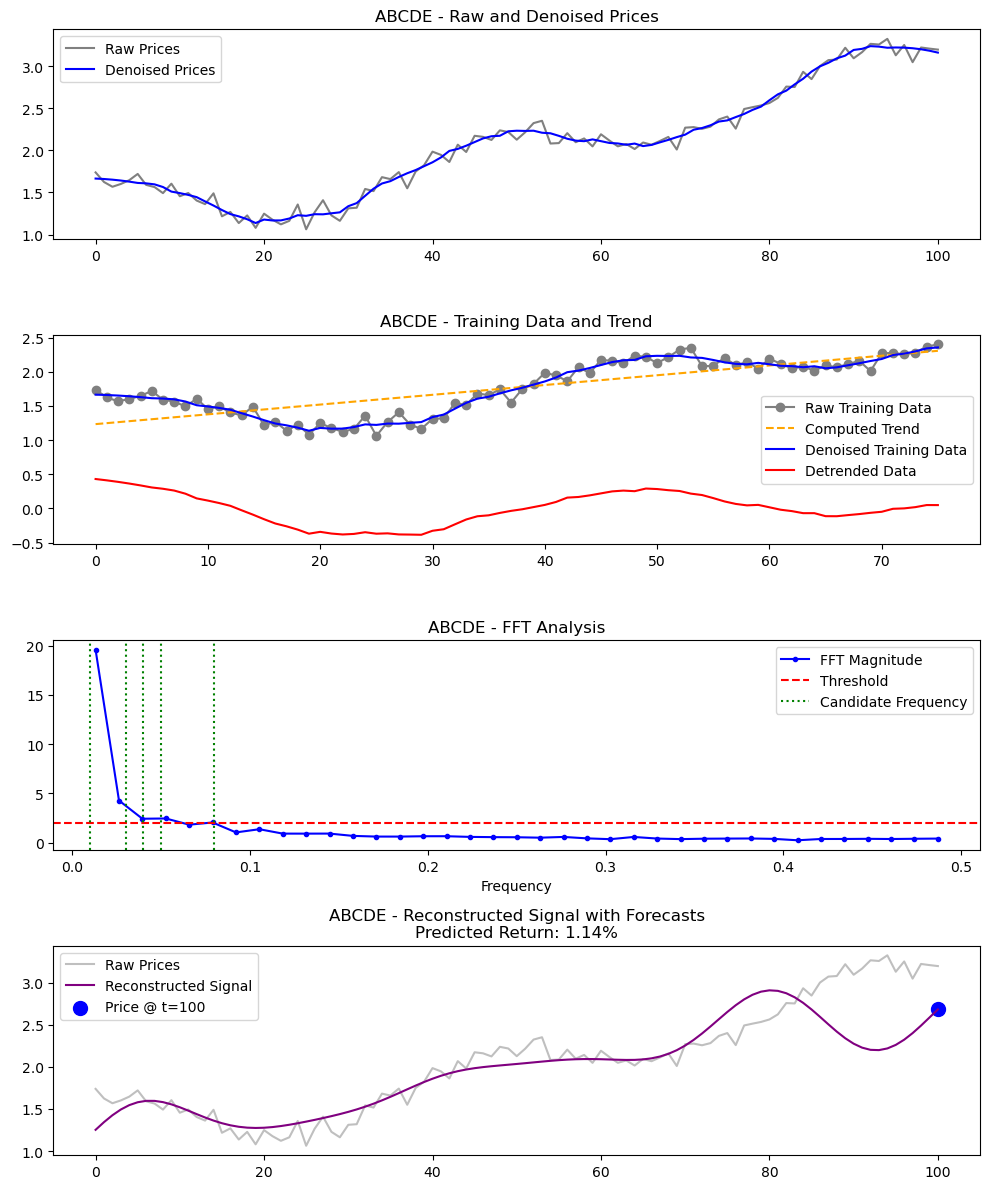

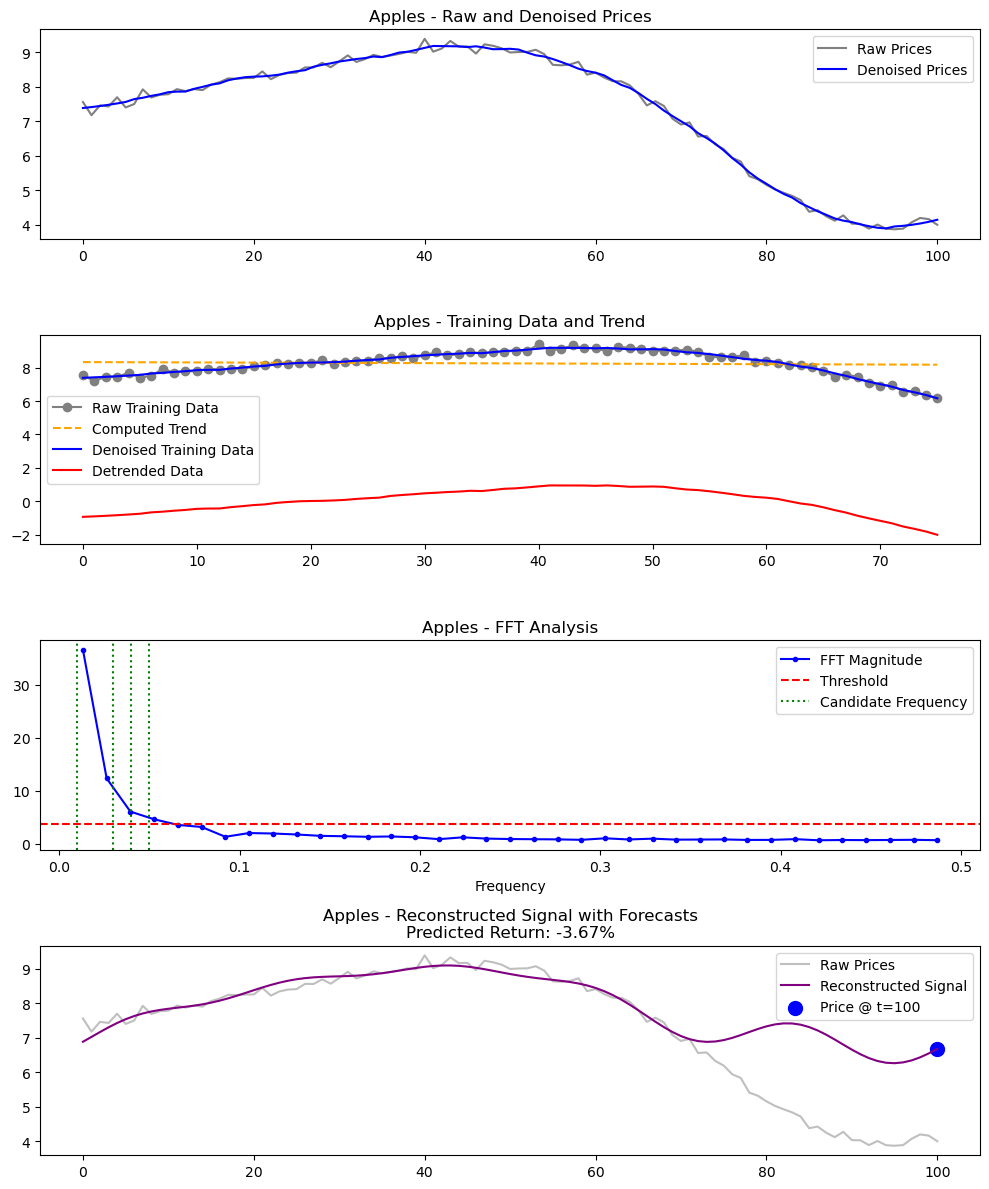

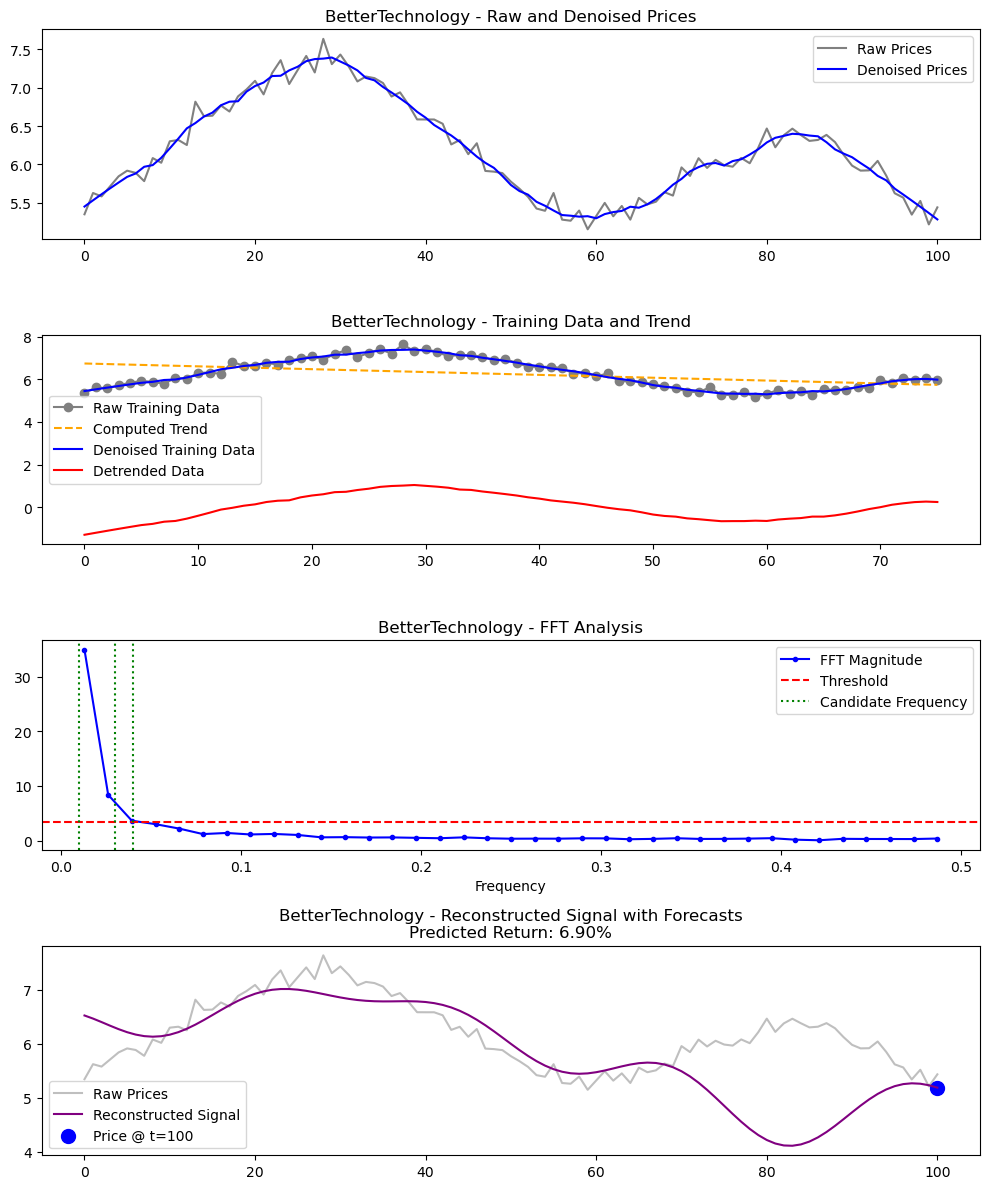

In [ ]:
from sklearn.linear_model import Lasso
from scipy.signal import savgol_filter
import numpy as np
import matplotlib.pyplot as plt

num_assets_to_process = 3 

training_start = 0
training_end = 75
forecast_time = 100
alpha = 0.01

for i, name in enumerate(asset_names[:num_assets_to_process]):
    # Convert lists to numpy arrays.
    times = np.array(asset_times[i])
    prices = np.array(asset_prices[i])
    
    # 1. Denoise the entire signal.
    prices_denoised = savgol_filter(prices, window_length=11, polyorder=2)
    
    # 2. Restrict to training data (t in [0,50]) and perform FFT on the denoised training data.
    mask = (times >= training_start) & (times <= training_end)
    t_train = times[mask]
    p_train_denoised = prices_denoised[mask]
    
    N = len(t_train)
    T = t_train[1] - t_train[0] if N > 1 else 1
    fft_vals = np.fft.fft(p_train_denoised)
    freq = np.fft.fftfreq(N, T)
    pos_mask = freq > 0
    freq_pos = freq[pos_mask]
    fft_magnitude = np.abs(fft_vals)[pos_mask]
    threshold = np.max(fft_magnitude) * 0.1
    candidate_frequencies = freq_pos[fft_magnitude > threshold]
    candidate_frequencies = np.unique(np.round(candidate_frequencies, 2))
    
    # 3. Compute trend on raw training data (to preserve the true slope).
    p_train_raw = prices[mask]
    coeffs_trend = np.polyfit(t_train, p_train_raw, 1)
    trend_train = np.polyval(coeffs_trend, t_train)
    
    # 4. Subtract the trend from the denoised training data.
    p_train_detrended = p_train_denoised - trend_train
    
    # 5. Build candidate library over the full time series.
    def build_candidate_library(x, candidate_frequencies):
        features = []
        feature_names = []
        features.append(np.ones_like(x))
        feature_names.append('1')
        features.append(x)
        feature_names.append('x')
        features.append(x**2)
        feature_names.append('x^2')
        for w in candidate_frequencies:
            features.append(np.sin(2 * np.pi * w * x))
            feature_names.append(f'sin(2π*{w:.2f}x)')
            features.append(np.cos(2 * np.pi * w * x))
            feature_names.append(f'cos(2π*{w:.2f}x)')
        X = np.column_stack(features)
        return X, feature_names
    
    X, _ = build_candidate_library(times, candidate_frequencies)
    X_train = X[mask, :]  # training subset
    
    # 6. Fit sparse regression (LASSO) on the detrended training data.
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train, p_train_detrended)
    coefs = lasso.coef_
    intercept_sparse = lasso.intercept_
    p_detrended_reconstructed = intercept_sparse + X.dot(coefs)
    
    # 7. Re-add the trend (extrapolated using the raw training trend).
    trend_full = np.polyval(coeffs_trend, times)
    p_reconstructed = p_detrended_reconstructed + trend_full
    
    # Final forecast values:
    price_at_training = np.interp(training_end, times, p_reconstructed)
    price_at_forecast = np.interp(forecast_time, times, p_reconstructed)
    predicted_return = (price_at_forecast - price_at_training) / price_at_training
    
    # --- Plotting intermediate results ---
    fig, axs = plt.subplots(4, 1, figsize=(10, 12))
    
    # Plot 1: Raw vs. Denoised Prices.
    axs[0].plot(times, prices, label="Raw Prices", color='gray')
    axs[0].plot(times, prices_denoised, label="Denoised Prices", color='blue')
    axs[0].set_title(f"{name} - Raw and Denoised Prices")
    axs[0].legend()
    
    # Plot 2: Training Data: raw, trend, denoised, and detrended.
    axs[1].plot(t_train, p_train_raw, 'o-', label="Raw Training Data", color='gray')
    axs[1].plot(t_train, trend_train, '--', label="Computed Trend", color='orange')
    axs[1].plot(t_train, p_train_denoised, label="Denoised Training Data", color='blue')
    axs[1].plot(t_train, p_train_detrended, label="Detrended Data", color='red')
    axs[1].set_title(f"{name} - Training Data and Trend")
    axs[1].legend()
    
    # Plot 3: FFT Magnitude and Candidate Frequencies.
    axs[2].plot(freq_pos, fft_magnitude, 'b.-', label="FFT Magnitude")
    axs[2].axhline(threshold, color='red', linestyle='--', label="Threshold")
    for idx, f in enumerate(candidate_frequencies):
        # Only label the first candidate frequency to avoid duplicate legend entries.
        label = "Candidate Frequency" if idx == 0 else ""
        axs[2].axvline(f, color='green', linestyle=':', label=label)
    axs[2].set_title(f"{name} - FFT Analysis")
    axs[2].set_xlabel("Frequency")
    axs[2].legend()
    
    # Plot 4: Reconstructed Signal and Forecasts.
    axs[3].plot(times, prices, label="Raw Prices", color='gray', alpha=0.5)
    axs[3].plot(times, p_reconstructed, label="Reconstructed Signal", color='purple')
    axs[3].scatter([forecast_time], [price_at_forecast],
                   color='blue', marker='o', s=100,
                   label=f"Price @ t={forecast_time}")
    axs[3].set_title(f"{name} - Reconstructed Signal with Forecasts\nPredicted Return: {predicted_return:.2%}")
    axs[3].legend()
    
    plt.tight_layout()
    plt.show()


Perform a simple linear regression (degree=1) for each asset using times in [0,100]. Extrapolate to time=200 to get a predicted price. Convert that predicted price growth into a predicted return \mu[i].

In [135]:
import numpy as np
from sklearn.linear_model import Lasso
from scipy.signal import savgol_filter

def baseline_forecast(asset_names, asset_times, asset_prices, training_start=0, training_end=100, forecast_time=200):
    """
    For each asset, fit a simple linear model on data in [training_start, training_end]
    and extrapolate to forecast_time. Computes expected return as:
      (price_at_forecast - price_at_training) / price_at_training.
    
    Returns a dictionary with, for each asset:
      - "model_predictions": (training_times, model_predictions) on [training_start, training_end]
      - "full_reconstruction": (recon_times, linear_reconstruction) on [training_start, forecast_time]
      - "price_at_training": predicted price at training_end
      - "price_at_forecast": predicted price at forecast_time
      - "predicted_return": computed return
    """
    baseline_pred = {}
    for i, name in enumerate(asset_names):
        times = np.array(asset_times[i])
        prices = np.array(asset_prices[i])
        # Use training data: times between training_start and training_end
        mask = (times >= training_start) & (times <= training_end)
        t_used = times[mask]
        p_used = prices[mask]
        coeffs = np.polyfit(t_used, p_used, deg=1)
        # Model predictions on training interval
        model_predictions = np.polyval(coeffs, t_used)
        price_at_training = np.polyval(coeffs, training_end)
        price_at_forecast = np.polyval(coeffs, forecast_time)
        predicted_return = (price_at_forecast - price_at_training) / price_at_training
        # Generate a new time vector for full reconstruction:
        recon_times = np.linspace(training_start, forecast_time, forecast_time - training_start)
        linear_reconstruction = np.polyval(coeffs, recon_times)
        
        baseline_pred[name] = {
            "model_predictions": (t_used, model_predictions),
            "full_reconstruction": (recon_times, linear_reconstruction),
            "price_at_training": price_at_training,
            "price_at_forecast": price_at_forecast,
            "predicted_return": predicted_return
        }
    return baseline_pred

def build_candidate_library(x, candidate_frequencies):
    """
    Build a design matrix with a constant, linear, quadratic term,
    and for each candidate frequency, sine and cosine functions.
    """
    features = []
    feature_names = []
    features.append(np.ones_like(x))
    feature_names.append('1')
    features.append(x)
    feature_names.append('x')
    features.append(x**2)
    feature_names.append('x^2')
    for w in candidate_frequencies:
        features.append(np.sin(2 * np.pi * w * x))
        feature_names.append(f'sin(2π*{w:.2f}x)')
        features.append(np.cos(2 * np.pi * w * x))
        feature_names.append(f'cos(2π*{w:.2f}x)')
    X = np.column_stack(features)
    return X, feature_names

def sparse_forecast(asset_names, asset_times, asset_prices, training_start=0, training_end=100, forecast_time=200, alpha=0.01):
    """
    For each asset, perform:
      1. Denoise the full signal.
      2. From training data ([training_start, training_end]), perform FFT on the denoised data
         to select candidate frequencies.
      3. Compute the linear trend using raw training data.
      4. Subtract the trend from the denoised training data.
      5. Build a candidate library over the full time series.
      6. Fit a sparse (LASSO) model on the detrended training data.
      7. Reconstruct the full signal (by adding back the extrapolated trend).
      8. Evaluate the learned function at any new x using the candidate library.
    
    Returns a dictionary with, for each asset:
      - "model_predictions": (training_times, model_predictions) on [training_start, training_end]
      - "full_reconstruction": (recon_times, p_reconstructed_new) over [training_start, forecast_time]
      - "price_at_training": predicted price at training_end (direct evaluation)
      - "price_at_forecast": predicted price at forecast_time (direct evaluation)
      - "predicted_return": computed return
    """
    sparse_pred = {}
    for i, name in enumerate(asset_names):
        times = np.array(asset_times[i])
        prices = np.array(asset_prices[i])
        
        # 1. Denoise the full signal.
        prices_denoised = savgol_filter(prices, window_length=11, polyorder=2)
        
        # 2. Restrict to training data and perform FFT on the denoised training data.
        mask = (times >= training_start) & (times <= training_end)
        t_train = times[mask]
        p_train_denoised = prices_denoised[mask]
        N = len(t_train)
        T = t_train[1] - t_train[0] if N > 1 else 1
        fft_vals = np.fft.fft(p_train_denoised)
        freq = np.fft.fftfreq(N, T)
        pos_mask = freq > 0
        freq_pos = freq[pos_mask]
        fft_magnitude = np.abs(fft_vals)[pos_mask]
        threshold = np.max(fft_magnitude) * 0.1
        candidate_frequencies = freq_pos[fft_magnitude > threshold]
        candidate_frequencies = np.unique(np.round(candidate_frequencies, 2))
        
        # 3. Compute trend using raw training data (to preserve the true slope).
        p_train_raw = prices[mask]
        coeffs_trend = np.polyfit(t_train, p_train_raw, 1)
        trend_train = np.polyval(coeffs_trend, t_train)
        
        # 4. Subtract the trend from the denoised training data.
        p_train_detrended = p_train_denoised - trend_train
        
        # 5. Build candidate library over the full time series.
        X, _ = build_candidate_library(times, candidate_frequencies)
        X_train = X[mask, :]
        
        # 6. Fit sparse regression (LASSO) on detrended training data.
        lasso = Lasso(alpha=alpha, max_iter=10000)
        lasso.fit(X_train, p_train_detrended)
        coefs = lasso.coef_
        intercept_sparse = lasso.intercept_
        
        # 7. Reconstruct the full signal.
        p_detrended_reconstructed = intercept_sparse + X.dot(coefs)
        trend_full = np.polyval(coeffs_trend, times)
        p_reconstructed = p_detrended_reconstructed + trend_full
        
        # 8. Define a prediction function that evaluates the learned function at any new x.
        def predict_new(x_new):
            X_new, _ = build_candidate_library(np.array([x_new]), candidate_frequencies)
            return (intercept_sparse + X_new.dot(coefs) + np.polyval(coeffs_trend, x_new)).item()
        
        price_at_training = predict_new(training_end)
        price_at_forecast = predict_new(forecast_time)
        predicted_return = (price_at_forecast - price_at_training) / price_at_training
        
        # Generate a new reconstruction time vector from training_start to forecast_time.
        recon_times = np.linspace(training_start, forecast_time, forecast_time - training_start)
        X_new, _ = build_candidate_library(recon_times, candidate_frequencies)
        p_detrended_new = intercept_sparse + X_new.dot(coefs)
        p_reconstructed_new = p_detrended_new + np.polyval(coeffs_trend, recon_times)
        
        sparse_pred[name] = {
            "model_predictions": (t_train, p_reconstructed[mask]),  # for diagnostic on training data
            "full_reconstruction": (recon_times, p_reconstructed_new),
            "price_at_training": price_at_training,
            "price_at_forecast": price_at_forecast,
            "predicted_return": predicted_return
        }
    return sparse_pred

# --- Compute Forecasts for Each Method ---
# (Assuming asset_names, asset_times, asset_prices have been loaded.)
results = {}
results["baseline"] = baseline_forecast(asset_names, asset_times, asset_prices,
                                          training_start=0, training_end=100, forecast_time=200)
results["sparse"] = sparse_forecast(asset_names, asset_times, asset_prices,
                                    training_start=0, training_end=100, forecast_time=200, alpha=0.01)

# --- Log Forecast Comparison Using Loop ---
for name in asset_names:
    print(f"Asset: {name}")
    for method, res in results.items():
        print(f"  {method.capitalize()} Forecast:")
        print(f"    Price at t=100: {res[name]['price_at_training']:.3f}")
        print(f"    Price at t=200: {res[name]['price_at_forecast']:.3f}")
        print(f"    Predicted Return: {res[name]['predicted_return']:.2%}")
    recon_times, p_rec = results["sparse"][name]["full_reconstruction"]
    print("-" * 40)

predicted_returns = np.array([results["baseline"][name]["predicted_return"] for name in asset_names])



Asset: ABCDE
  Baseline Forecast:
    Price at t=100: 3.049
    Price at t=200: 5.022
    Predicted Return: 64.71%
  Sparse Forecast:
    Price at t=100: 3.353
    Price at t=200: 8.334
    Predicted Return: 148.58%
----------------------------------------
Asset: Apples
  Baseline Forecast:
    Price at t=100: 5.156
    Price at t=200: 0.811
    Predicted Return: -84.26%
  Sparse Forecast:
    Price at t=100: 3.535
    Price at t=200: -33.384
    Predicted Return: -1044.42%
----------------------------------------
Asset: BetterTechnology
  Baseline Forecast:
    Price at t=100: 5.736
    Price at t=200: 4.846
    Predicted Return: -15.52%
  Sparse Forecast:
    Price at t=100: 5.427
    Price at t=200: 5.445
    Predicted Return: 0.33%
----------------------------------------
Asset: BetterTomorrow
  Baseline Forecast:
    Price at t=100: 5.615
    Price at t=200: 6.719
    Predicted Return: 19.66%
  Sparse Forecast:
    Price at t=100: 5.797
    Price at t=200: 10.666
    Predicted Ret

Illustrate your predictions by plotting the historical data and the linear fit for a few assets, plus the forecasted price at t=200.


Asset: ABCDE
  Baseline Forecast:
    Price at t=100: 3.049
    Price at t=200: 5.022
    Predicted Return: 64.71%
  Sparse Forecast:
    Price at t=100: 3.353
    Price at t=200: 8.334
    Predicted Return: 148.58%


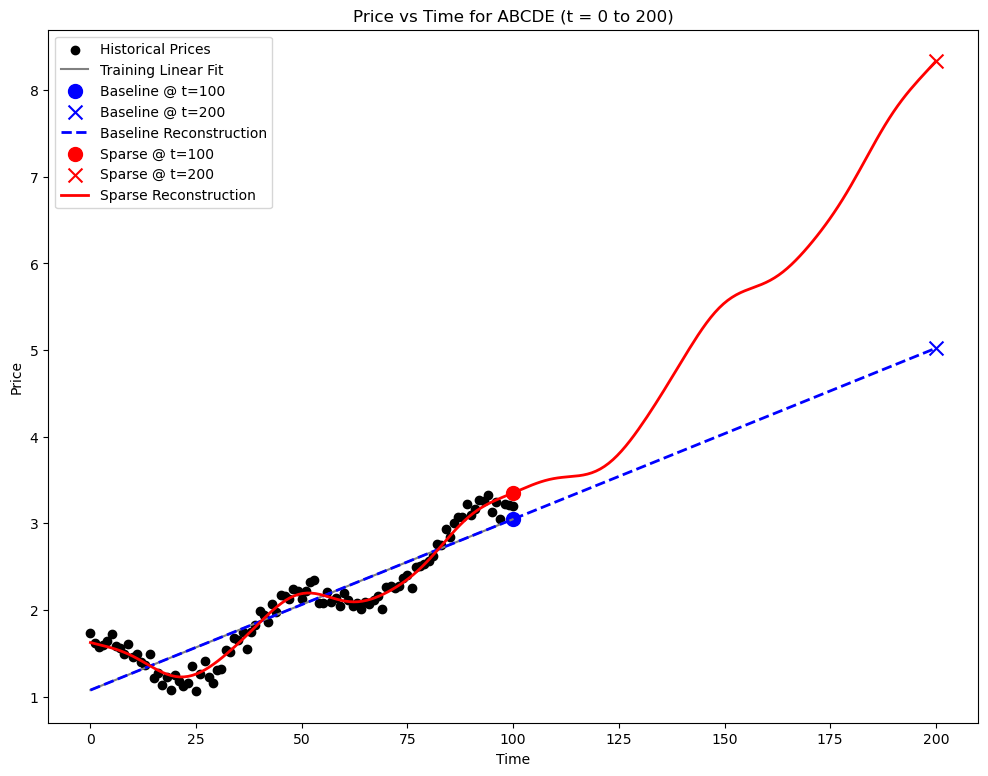


Asset: Apples
  Baseline Forecast:
    Price at t=100: 5.156
    Price at t=200: 0.811
    Predicted Return: -84.26%
  Sparse Forecast:
    Price at t=100: 3.535
    Price at t=200: -33.384
    Predicted Return: -1044.42%


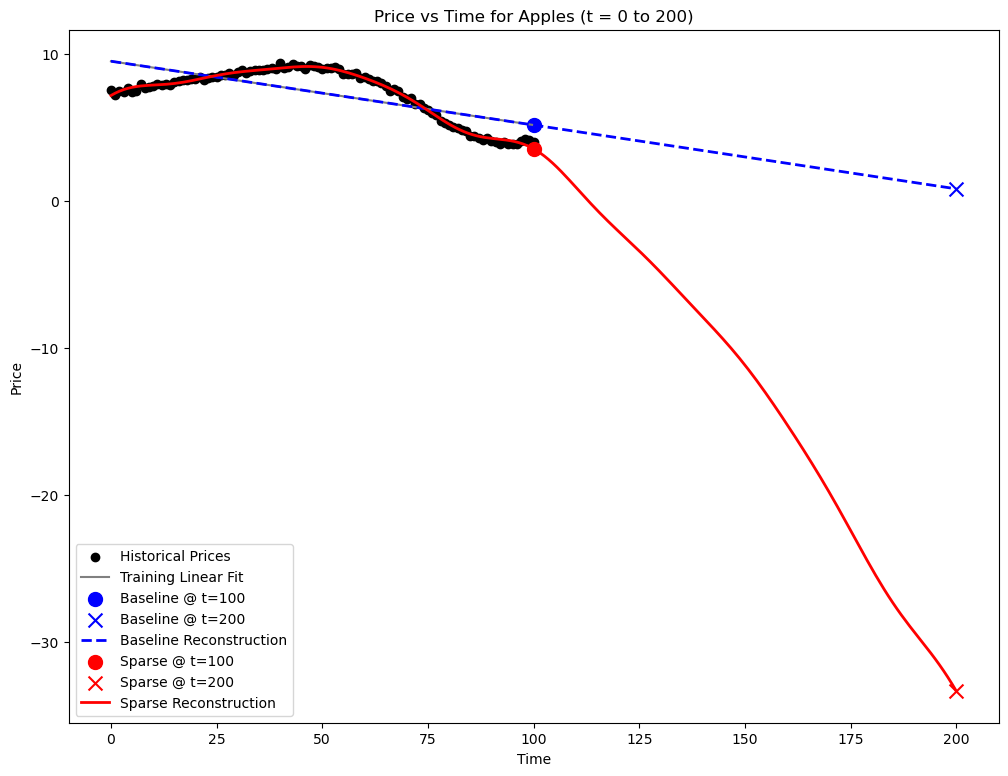


Asset: BetterTechnology
  Baseline Forecast:
    Price at t=100: 5.736
    Price at t=200: 4.846
    Predicted Return: -15.52%
  Sparse Forecast:
    Price at t=100: 5.427
    Price at t=200: 5.445
    Predicted Return: 0.33%


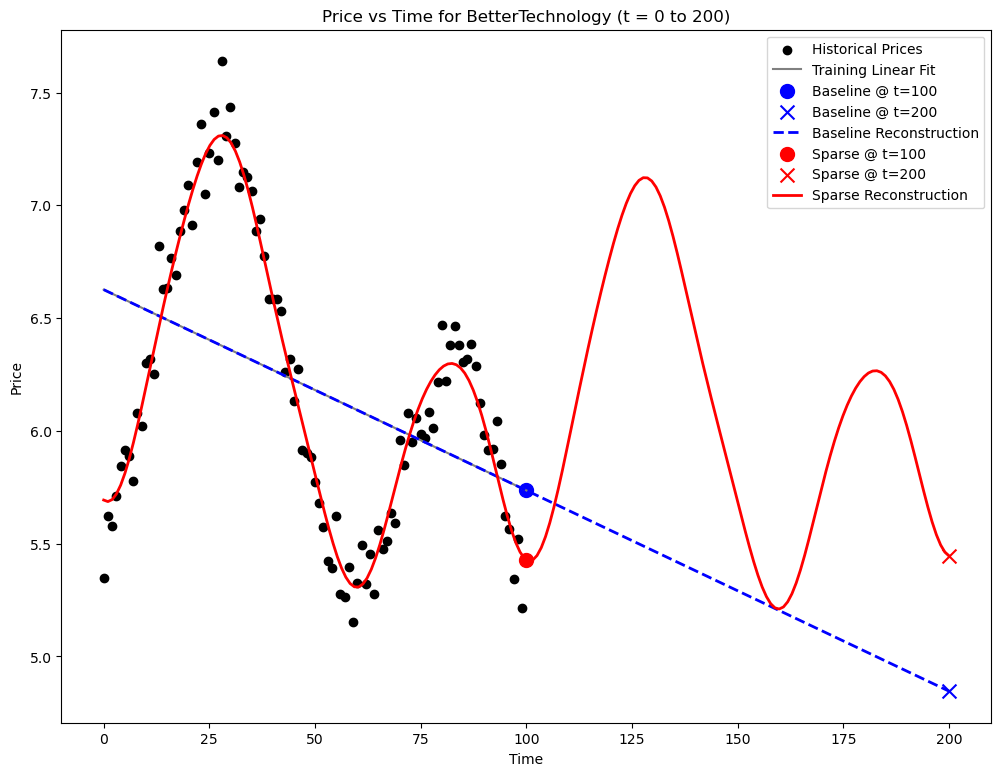

In [142]:
import matplotlib.pyplot as plt
import numpy as np

methods = list(results.keys())  # e.g., ["baseline", "sparse"]
num_to_plot = min(3, len(asset_names))

for i in range(num_to_plot):
    asset = asset_names[i]
    times = np.array(asset_times[i])
    prices = np.array(asset_prices[i])
    
    # Print forecast predictions for the asset.
    print(f"\nAsset: {asset}")
    for method in methods:
        res = results[method][asset]
        print(f"  {method.capitalize()} Forecast:")
        print(f"    Price at t=100: {res['price_at_training']:.3f}")
        print(f"    Price at t=200: {res['price_at_forecast']:.3f}")
        print(f"    Predicted Return: {res['predicted_return']:.2%}")
    
    # Compute a training linear fit on historical data (t <= 100) for reference.
    mask_train = times <= 100
    coeffs = np.polyfit(times[mask_train], prices[mask_train], deg=1)
    fit_line = np.polyval(coeffs, times)
    
    plt.figure(figsize=(12,9))
    plt.scatter(times, prices, label="Historical Prices", color="black")
    plt.plot(times, fit_line, label="Training Linear Fit", color="gray")
    
    # Plot forecast markers for each method.
    colors = {"baseline": "blue", "sparse": "red"}
    markers = {"baseline": {"t100": "o", "t200": "x"}, "sparse": {"t100": "o", "t200": "x"}}
    for method in methods:
        res = results[method][asset]
        plt.scatter([100], [res["price_at_training"]], marker=markers[method]["t100"],
                    color=colors[method], s=100, label=f"{method.capitalize()} @ t=100")
        plt.scatter([200], [res["price_at_forecast"]], marker=markers[method]["t200"],
                    color=colors[method], s=100, label=f"{method.capitalize()} @ t=200")
        recon_times, reconstruction = results[method][asset]["full_reconstruction"]
        linestyle = "--" if method == "baseline" else "-"
        plt.plot(recon_times, reconstruction, label=f"{method.capitalize()} Reconstruction",
                 color=colors[method], linestyle=linestyle, linewidth=2)

    plt.title(f"Price vs Time for {asset} (t = 0 to 200)")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()


Build the Markowitz Model Inputs

- $\mu[i]$ comes from the predicted returns (time=100 to time=200).
- $\Sigma$ is estimated from the historical returns from the adjacency in your original price data (0..100).

In [137]:
################################################################################
# CELL 5: Build Markowitz Model Inputs
#   - We have a predicted return for each asset from t=100 -> t=200: predicted_returns
#     => We'll call this mu[i].
#   - Next, we need a covariance matrix from historical returns in [0..100].
################################################################################

# We'll compute sample returns for each asset from t_k to t_(k+1) and build the sample covariance.

n_assets = len(asset_names)
all_historical_returns = []
max_periods = None

for i in range(n_assets):
    p = np.array(asset_prices[i])
    returns_i = []
    for k in range(len(p) - 1):
        if p[k] != 0:
            ret_k = (p[k+1] - p[k]) / p[k]
        else:
            ret_k = 0.0
        returns_i.append(ret_k)

    if max_periods is None:
        max_periods = len(returns_i)
    else:
        max_periods = min(max_periods, len(returns_i))

    all_historical_returns.append(returns_i)

# Truncate all to the same length
for i in range(n_assets):
    all_historical_returns[i] = all_historical_returns[i][:max_periods]

all_historical_returns = np.array(all_historical_returns).T  # shape (max_periods, n_assets)
print("all_historical_returns shape:", all_historical_returns.shape)

Sigma = np.cov(all_historical_returns, rowvar=False)
mu = predicted_returns

all_historical_returns shape: (100, 20)


Implement the two multi-objective methods:
- Weighted Sum Method (WSM)
  For each \(\alpha\in[0,1]\), solve \(\min \alpha (x^T\Sigma x) - (1-\alpha) (\mu^T x).\)
- Epsilon-Constraint Method (ECM)
  For each target return \(r\), solve \(\min x^T\Sigma x\) subject to \(\mu^T x \ge r.\)

In [138]:
################################################################################
# CELL 6: Implement WSM and ECM
#   Weighted Sum Method (WSM):
#     min alpha * x^T Sigma x  - (1 - alpha)* mu^T x
#     s.t. sum(x) = 1, x >= 0
#   Epsilon-Constraint Method (ECM):
#     min x^T Sigma x
#     s.t. mu^T x >= r, sum(x)=1, x>=0
################################################################################

def solve_qp_cvxopt(Q, c, A=None, b=None, G=None, h=None, show_progress=False):
    solvers.options['show_progress'] = show_progress
    Q_cvx = matrix(Q, tc='d')
    c_cvx = matrix(c, tc='d')
    A_cvx = matrix(A, tc='d') if A is not None else None
    b_cvx = matrix(b, tc='d') if b is not None else None
    G_cvx = matrix(G, tc='d') if G is not None else None
    h_cvx = matrix(h, tc='d') if h is not None else None
    solution = solvers.qp(Q_cvx, c_cvx, G_cvx, h_cvx, A_cvx, b_cvx)
    x_opt = np.array(solution['x']).flatten()
    return x_opt, solution['primal objective']

def wsm_portfolios(mu, Sigma, num_points=11):
    n = len(mu)

    A = np.ones((1, n))
    b = np.array([1.0])
    G = -1.0 * np.eye(n)
    h = np.zeros(n)

    alpha_list = np.linspace(0, 1, num_points)
    results_risk = []
    results_return = []
    results_weights = []

    for alpha in alpha_list:
        # objective = alpha*x^T Sigma x - (1-alpha)* mu^T x
        # => in cvxopt form: 0.5*x^T(2 alpha Sigma)x + c^T x
        # => Q = 2 alpha Sigma, c = -(1-alpha)*mu
        Q_eff = 2.0 * alpha * Sigma
        c_eff = -(1.0 - alpha) * mu

        x_opt, _ = solve_qp_cvxopt(Q_eff, c_eff, A=A, b=b, G=G, h=h)
        risk_val = x_opt @ Sigma @ x_opt
        ret_val = x_opt @ mu

        results_risk.append(risk_val)
        results_return.append(ret_val)
        results_weights.append(x_opt)

    return np.array(results_risk), np.array(results_return), np.array(results_weights)

def ecm_portfolios(mu, Sigma, num_points=11):
    n = len(mu)
    A = np.ones((1, n))
    b = np.array([1.0])
    base_G = -1.0 * np.eye(n)
    base_h = np.zeros(n)

    r_min, r_max = mu.min(), mu.max()
    r_values = np.linspace(r_min, r_max, num_points)

    results_risk = []
    results_return = []
    results_weights = []

    for r in r_values:
        # mu^T x >= r => -mu^T x <= -r
        G_extended = np.vstack([base_G, -mu.reshape(1,-1)])
        h_extended = np.concatenate([base_h, np.array([-r])])

        Q_eff = 2.0 * Sigma
        c_eff = np.zeros(n)

        try:
            x_opt, _ = solve_qp_cvxopt(Q_eff, c_eff, A=A, b=b, G=G_extended, h=h_extended)
            risk_val = x_opt @ Sigma @ x_opt
            ret_val = x_opt @ mu
            if ret_val >= r - 1e-6:
                results_risk.append(risk_val)
                results_return.append(ret_val)
                results_weights.append(x_opt)
        except:
            # might be infeasible
            continue

    return np.array(results_risk), np.array(results_return), np.array(results_weights)


 - Run WSM and ECM with different numbers of sample points (e.g., num_points=5,11,21,51).
 - Plot the resulting Pareto fronts.
 - Compare how many unique solutions each approach yields (some alphas produce the same optimum).

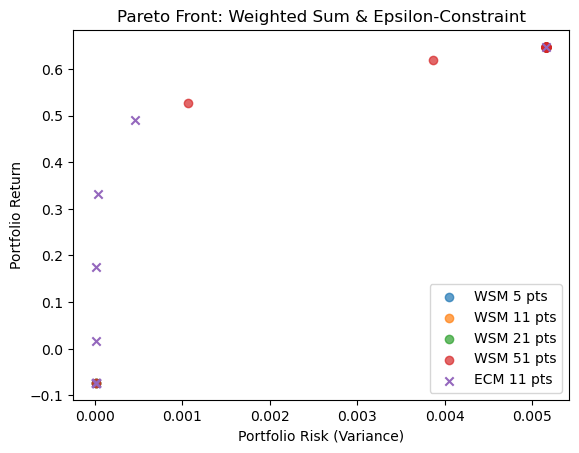

[WSM] alpha steps =  5 => found 2 unique (risk,return) solutions.
[WSM] alpha steps = 11 => found 2 unique (risk,return) solutions.
[WSM] alpha steps = 21 => found 3 unique (risk,return) solutions.
[WSM] alpha steps = 51 => found 6 unique (risk,return) solutions.
[ECM]  11 steps => found 11 unique (risk,return) solutions.


In [139]:
################################################################################
# CELL 7: Run & Compare For Different Calculation Limits, Plot Pareto Front
################################################################################

points_list = [5, 11, 21, 51]

plt.figure()
for num_points in points_list:
    wsm_risk, wsm_ret, _ = wsm_portfolios(mu, Sigma, num_points=num_points)
    plt.scatter(wsm_risk, wsm_ret, label=f"WSM {num_points} pts", alpha=0.7)

# ECM with 11 points
ecm_risk, ecm_ret, _ = ecm_portfolios(mu, Sigma, num_points=11)
plt.scatter(ecm_risk, ecm_ret, marker='x', label="ECM 11 pts")

plt.xlabel("Portfolio Risk (Variance)")
plt.ylabel("Portfolio Return")
plt.title("Pareto Front: Weighted Sum & Epsilon-Constraint")
plt.legend()
plt.show()

# Compare how many unique solutions each method returns.
for num_points in points_list:
    wsm_risk, wsm_ret, wsm_wts = wsm_portfolios(mu, Sigma, num_points=num_points)
    risk_ret_pairs = np.round(np.column_stack((wsm_risk, wsm_ret)), 6)
    unique_pairs = np.unique(risk_ret_pairs, axis=0)
    print(f"[WSM] alpha steps = {num_points:2d} => found {len(unique_pairs)} unique (risk,return) solutions.")

ecm_risk, ecm_ret, ecm_wts = ecm_portfolios(mu, Sigma, num_points=11)
risk_ret_pairs = np.round(np.column_stack((ecm_risk, ecm_ret)), 6)

# finalize the unique solution count for ECM
unique_ecm = np.unique(risk_ret_pairs, axis=0)
print(f"[ECM]  11 steps => found {len(unique_ecm)} unique (risk,return) solutions.")

## Interpretation of the Pareto Plots and Unique Solutions

1. **Plot Description**  
   - The *x-axis* represents the **portfolio risk** (variance). Lower values mean less risk.  
   - The *y-axis* represents the **portfolio return** predicted by the model. Higher values mean higher return.  
   - Each marker represents a different **optimal portfolio** found by the optimization method (WSM or ECM).

2. **Weighted Sum Method (WSM)**  
   - We vary the parameter $\alpha \in [0,1]$ in discrete steps.  
   - The model tries to minimize $\alpha \times \text{risk} - (1-\alpha) \times \text{return}$.  
   - We count how many *unique* (risk, return) portfolios arise for different $\alpha$.  

3. **Epsilon-Constraint Method (ECM)**  
   - We vary a target return $r$.  
   - We minimize $\text{risk}$ subject to meeting or exceeding $r$.  

4. **Observations & Conclusions**  
   - Both methods identify *efficient (Pareto-optimal) portfolios*.  
   - **WSM solutions** can cluster if the same portfolio is optimal for multiple $\alpha$.  
   - **ECM solutions** sample the frontier by specifying returns.  

5. **Next Steps**  
   - Increase the number of steps to get a denser approximation of the front.  
   - For checkpoint 1, you have a working script that loads data, predicts returns, builds the covariance matrix, and solves the multi-objective Markowitz model via WSM and ECM.  
   - Plot and interpret your results.

# Portofolio Game Results

In [140]:
################################################################################
# CELL 8: Dynamic Approach - Pick Best Risk/Reward Balance Automatically
################################################################################

# 1) Get multiple portfolios via Weighted Sum Method
wsm_risk, wsm_ret, wsm_wts = wsm_portfolios(mu, Sigma, num_points=51)

# 2) Define a "score" to pick the best trade-off
#    We'll use a simple ratio (return / sqrt(risk)), a rough Sharpe-style measure.
best_idx = 0
best_score = -999
for i in range(len(wsm_wts)):
    score = wsm_ret[i] / ( (wsm_risk[i] + 1e-9)**0.5 )  # avoid division by zero
    if score > best_score:
        best_score = score
        best_idx = i

chosen_risk   = wsm_risk[best_idx]
chosen_return = wsm_ret[best_idx]
chosen_weights = wsm_wts[best_idx]

# 3) Reorder according to the required list
required_order = [
    "SuperFuture","Apples","WorldNow","Electronics123","Photons","SpaceNow",
    "PearPear","PositiveCorrelation","BetterTechnology","ABCDE","EnviroLike",
    "Moneymakers","Fuel4","MarsProject","CPU-XYZ","RoboticsX","Lasers",
    "WaterForce","SafeAndCare","BetterTomorrow"
]
idx_map = {name: i for i, name in enumerate(asset_names)}
reordered_w = [chosen_weights[idx_map[n]] for n in required_order]

# 4) Format output (return, risk, weights)
final_return  = 100.0 * (1 + chosen_return)
final_risk    = 100.0 * chosen_risk
fields = [f"{final_return:.2f}", f"{final_risk:.2f}"] + [f"{w:.2f}" for w in reordered_w]
line_out = " ".join(fields)

# 5) Save to a txt file
filename = "151958_151960.txt"
with open(filename, "w") as f:
    f.write(line_out + "\n")

print("Final line:", line_out)
print("Saved to", filename)

Final line: 152.70 0.11 0.00 0.00 0.20 0.00 0.00 0.00 0.00 0.00 0.00 0.46 0.00 0.15 0.00 0.00 0.00 0.00 0.00 0.19 0.00 0.00
Saved to 151958_151960.txt


**Interpretation:**
- **First number (152.70):** The expected total return in scaled form (we multiplied by 100×(1+return)). It suggests about a +52.70% increase over a 100 baseline.
- **Second number (0.11):** The portfolio’s total risk (e.g., variance × 100 in our code).  
- **Next 20 values:** The portfolio weights, one for each asset in the order given by the instructions:

  1. SuperFuture  
  2. Apples  
  3. WorldNow  
  4. Electronics123  
  5. Photons  
  6. SpaceNow  
  7. PearPear  
  8. PositiveCorrelation  
  9. BetterTechnology  
  10. ABCDE  
  11. EnviroLike  
  12. Moneymakers  
  13. Fuel4  
  14. MarsProject  
  15. CPU-XYZ  
  16. RoboticsX  
  17. Lasers  
  18. WaterForce  
  19. SafeAndCare  
  20. BetterTomorrow  

From the weights:

- **WorldNow** (3rd in the list) has 0.20,
- **ABCDE** (10th) has 0.46,
- **Moneymakers** (12th) has 0.15,
- **WaterForce** (18th) has 0.19,

while everything else is 0.00. That totals to ~100% and yields a predicted higher return relative to its overall risk, according to the solver’s “best ratio of return to √risk.”

This kind of solution indicates that four assets out of the set dominate the risk–reward ratio in our Weighted Sum approach with a Sharpe-like criterion. If you wish to adjust diversification further, you can modify how we select the “best” portfolio or change the risk–return scoring function.